# Segementación de Clientes de Olist

# **Documentación**

- Numpy --> https://numpy.org/doc/stable/reference/index.html
- Pandas --> https://pandas.pydata.org/pandas-docs/stable/reference/index.html
- Scikit-Learn --> https://scikit-learn.org/stable/
- Sklearn (Api Reference) --> https://scikit-learn.org/stable/modules/classes.html
- Estilos pyplot --> https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
- Funcionamiento de KMeans de manera visual --> https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
- Más información --> https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

# **Carpetas**

In [1]:
# Genero las carpetas que se van a utilizar a lo largo del notebook
import os
for i in ['data', 'report', 'pickle', 'final']:
    try:
        os.mkdir(i)
    except FileExistsError:
        pass

Descargamos las bases de datos y las guardamos en la carpeta 'data':
- order customer dataset ... https://drive.google.com/file/d/1GcuhEnIpuTV8vRktiPtK0aIQsz3fd94T/view?usp=drive_link
- orders dataset ... https://drive.google.com/file/d/1uf-5R1J1OvT95LMlCe9VpP7qAceabUUt/view?usp=drive_link
- order payments dataset ... https://drive.google.com/file/d/1aAhs4iNGa03F66KmhElvIgjpxJ_bQaZ1/view?usp=drive_link

# **Rutas**

In [2]:
# Usando Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
CWD = os.getcwd() # ruta actual
IMAGES_PATH = os.path.join(CWD, "pictures") # ruta de imágenes
DATA_PATH = os.path.join(CWD, "data") # ruta de datos

# **Objetivo**

Olist es una empresa brasileña de e-commerce cuyo funcionamiento es similar a Amazon.\
Opera con una filosofía SaaS (Software as a service).\
Su principal línea de negocio es un marketplace, en el que tiendas con o sin presencia física pueden vender sus productos.

A continuación se puede ver la estructura de su base de datos:

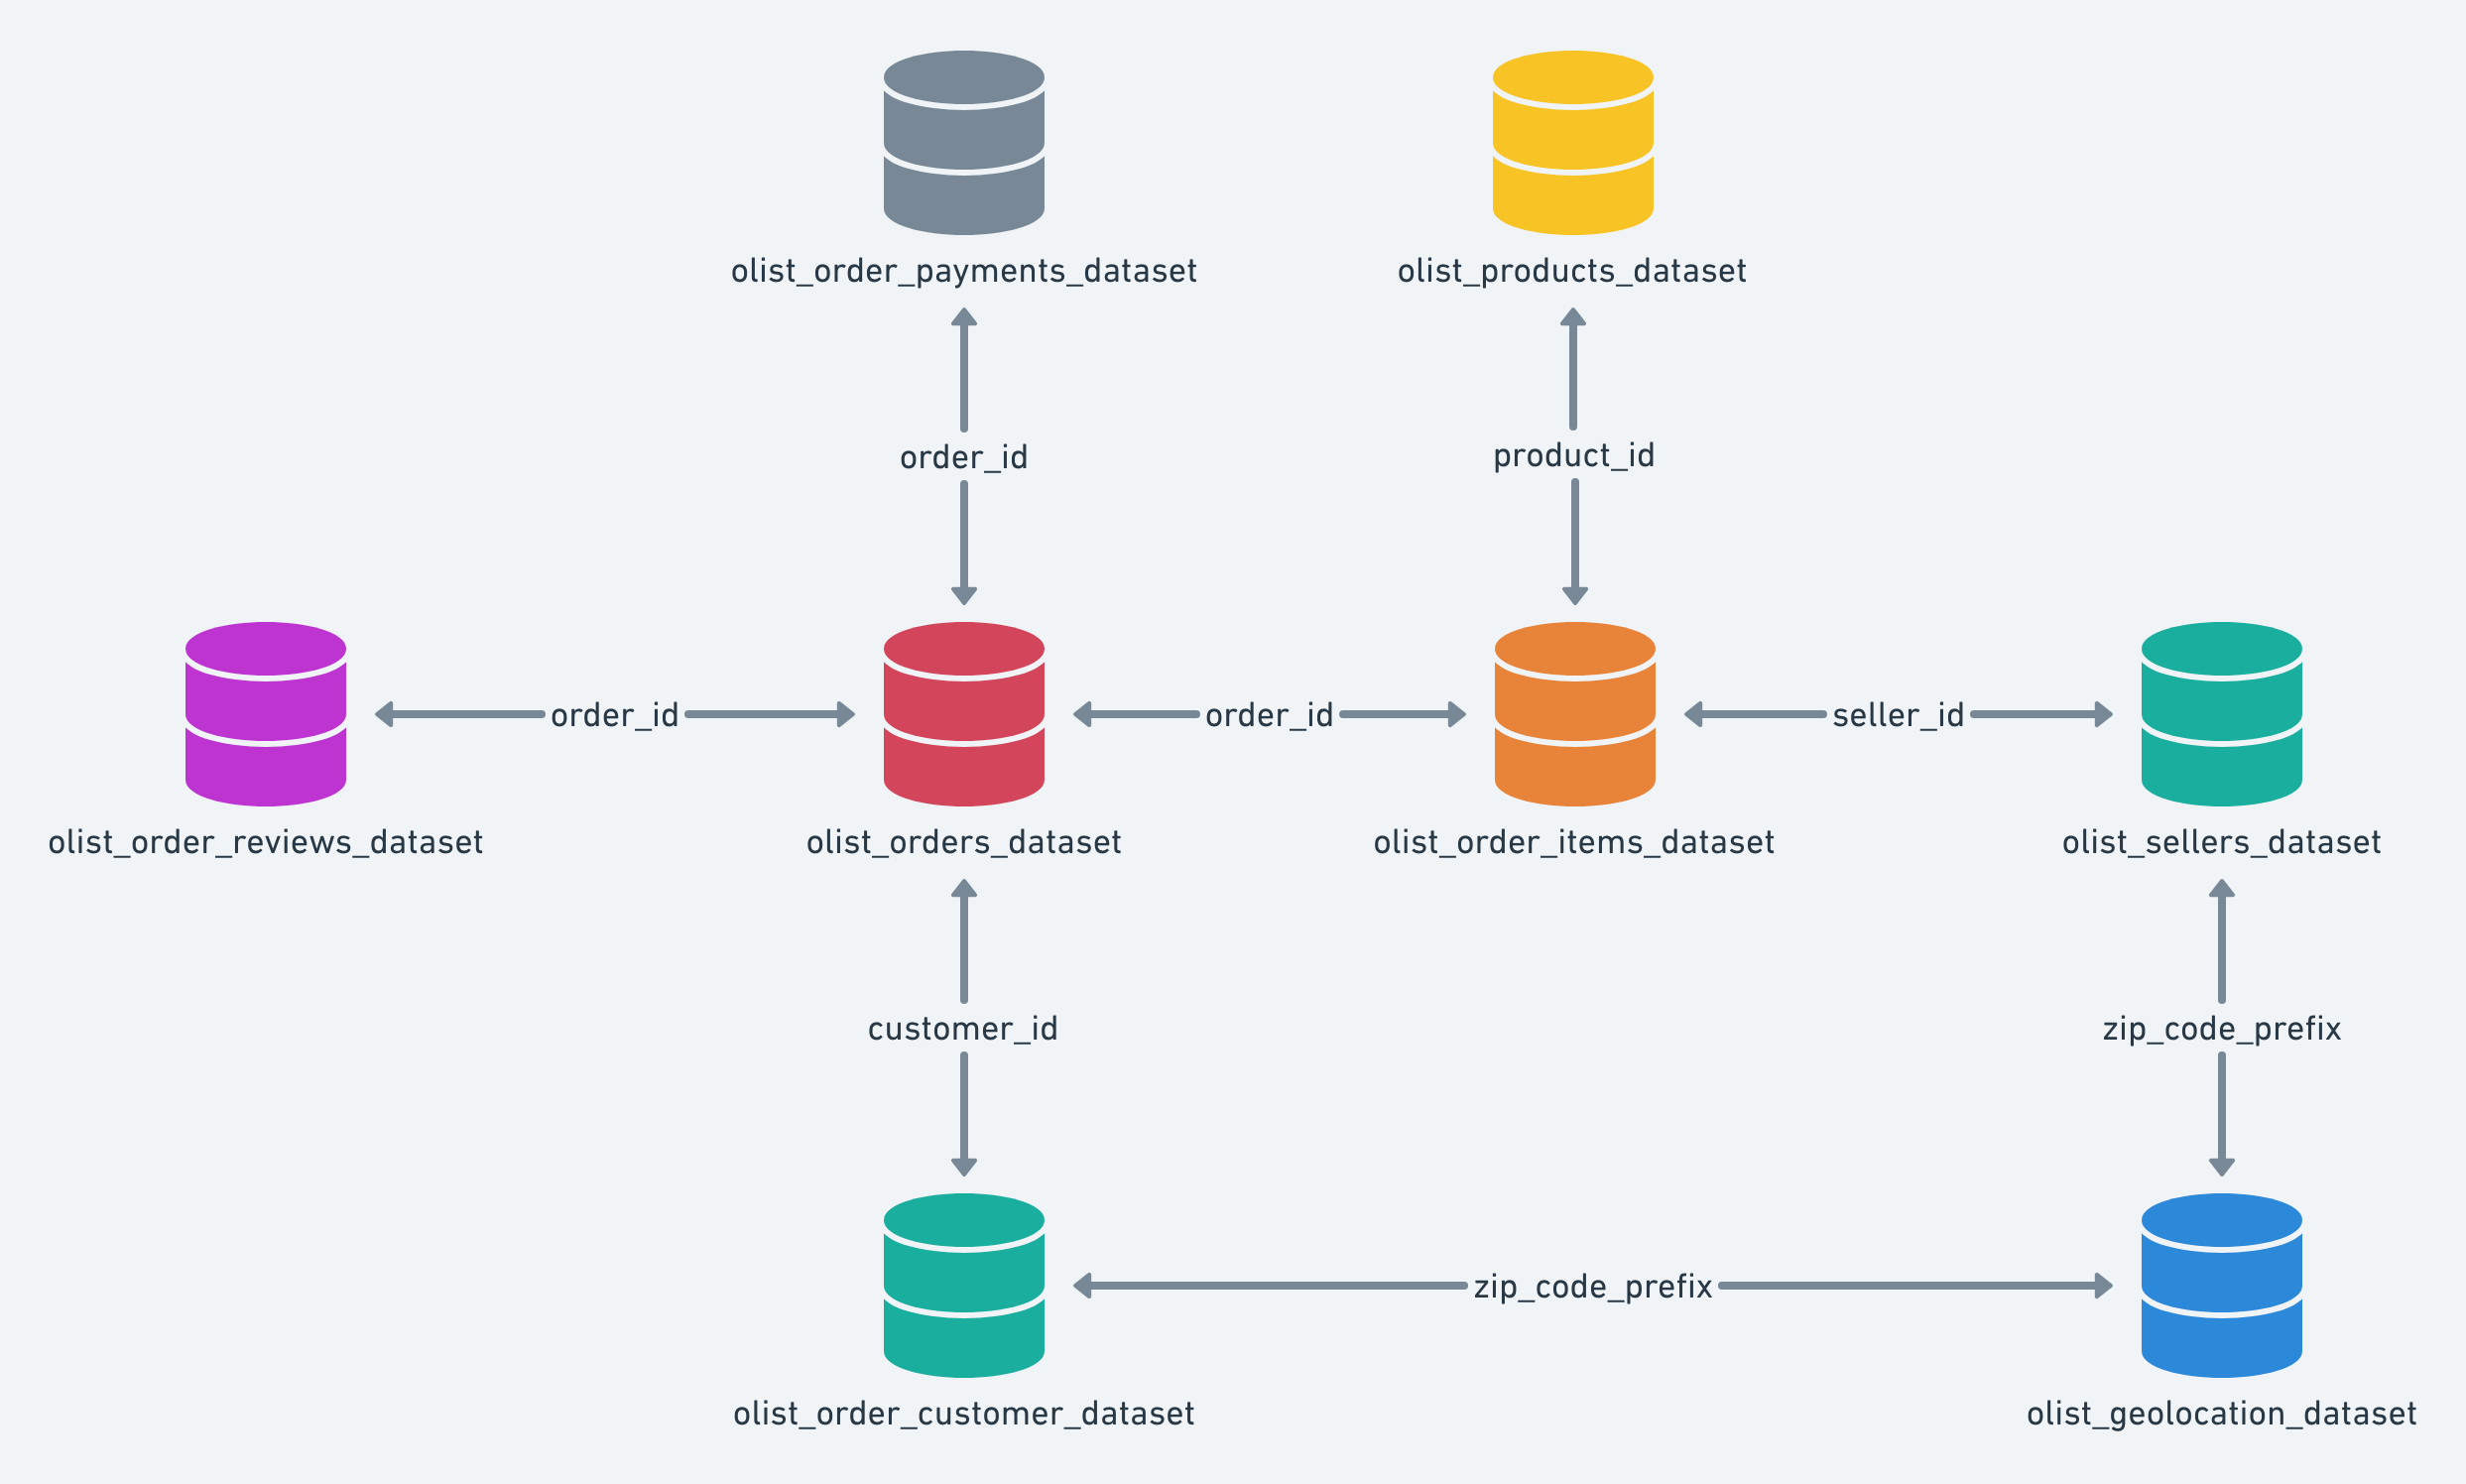

In [4]:
from IPython.display import Image
Image(filename = IMAGES_PATH+'/BBDD_Olist.png')

Utilizando el dataset de Olist, vamos a construir una segmentacion basada en el algoritmo KMeans. 

Se utilizará la estrategia de marketing ***RFM (recency:clientes en función de compras más recientes - frequency: clientes en función de la frecuencia de compra - monetary value:clientes en función del valor monetario de una transaccion)***, para hacer la segmentación de clientes. Esta técnica de marketing es muy común en startups y tiendas online donde se dispone de poca información de los clientes, y sirve para segmentar a los clientes según su importancia para el negocio, teniendo en cuenta los 3 criterios. De esa manera podemos saber:
* quienes son mis mejores clientes
* quienes están mas cerca de no volver a comprar nunca
* qué clientes he perdido definitivamente
* en qué grupo conviene invertir un exfuerzo extra para conservarlos como clientes, etc

Nuestros principales objetivos serán:
1. **Construir variables de negocio** (pensadas para nuestra segmentación).

2. Usar el diagrama del codo (elbow curve) para determinar la **cantidad "óptima" de centroides** para el modelo de KMeans.

3. Resumir la información de nuestros clústers en una ficha usando Pandas (**fichas de clientes**).

# **1. IMPORTACIÓN DE LIBRERÍAS**

In [87]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances

In [6]:
print("sklearn version {}".format(sklearn.__version__))

sklearn version 1.3.0


**FUNCIONES Y CLASES**

In [7]:
# Elimina duplicados
def drop_duplicates (dataframe):
    '''
    Elimina filas duplicadas del dataset
    '''
    print(f"Shape antes: {dataframe.shape}")
    df_duplicated = dataframe[dataframe.duplicated(keep = False)]
    print(f"Se han eliminado {len(dataframe[dataframe.duplicated()])} registros repetidos")
    dataframe.drop_duplicates(inplace = True)

    if len(dataframe[dataframe.duplicated()])>0:
            return df_duplicated
    print(f"Shape despues: {dataframe.shape}")

In [8]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos\n")
    print("Cinco primeros registros del dataset:")
    return df.head()

In [9]:
# Añadiendo el BaseEstimator, TransformerMixi, podemos acceder a sus métodos por herencia --> fit-transform
# con el self ato la función a la clase
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None): # parámetros iniciales que le tengo que pasar a la clase
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None): 
        return self # no hay nada que entrenar
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

In [10]:
# Añadiendo el BaseEstimator, TransformerMixi, podemos acceder a sus métodos por herencia --> fit-transform
# con el self ato la función a la clase
class FeatureGenerator(BaseEstimator, TransformerMixin): 
    '''
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    '''
    
    def __init__(self):
        pass # No le tengo que pasar nada
    
    def fit(self, X, y = None):
        return self # No tengo que aprender nada
    
    def transform(self, X, y = None):

    # El dataframe que le paso lo agrego según las variables que tocan    
        aggregated_df = X.groupby(X.index).agg(
            n_orders = ('total_pay', 'count'),
            amount = ('total_pay', 'sum'),
            avg_ticket = ('total_pay', 'mean'),
            
            last_purchase = ('time_since_last_purchase', 'min'),
            first_purchase = ('time_since_last_purchase', 'max'),
            
            mean_delivery_time = ('delivery_time', 'mean'),
            max_delivery_time = ('delivery_time', 'max'),
            
            mean_delay = ('delay', 'mean'),
            max_delay = ('delay', 'max')
        )
        
        return aggregated_df

In [11]:
# Añadiendo el BaseEstimator, TransformerMixi, podemos acceder a sus métodos por herencia --> fit-transform
# con el self ato la función a la clase
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter): # parámetros iniciales que le tengo que pasar a la clase --> cuantiles y columnas que queremos filtrar
        self.q = q # percentil
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self # No hay nada que entrenar
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q) # Calcula en base al percentil q
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

# **2. IMPORTACIÓN DE DATOS**

In [12]:
# dataset de clientes
customers_df = pd.read_csv(DATA_PATH+'/kmeans_olist_customers_dataset.csv')

# dataset de pedidos
orders_df = pd.read_csv(DATA_PATH+'/kmeans_olist_orders_dataset.csv')

# dataset de pagos
payments_df = pd.read_csv(DATA_PATH+'/kmeans_olist_order_payments_dataset.csv')

Vemos si hay **registros repetidos en los datasets**, y los eliminamos

In [13]:
drop_duplicates (dataframe = customers_df)

Shape antes: (99441, 5)


Se han eliminado 0 registros repetidos
Shape despues: (99441, 5)


In [14]:
drop_duplicates (dataframe = orders_df)

Shape antes: (99441, 8)
Se han eliminado 0 registros repetidos
Shape despues: (99441, 8)


In [15]:
drop_duplicates (dataframe = payments_df)

Shape antes: (103886, 5)
Se han eliminado 0 registros repetidos
Shape despues: (103886, 5)


# **3. DATA UNDERSTANDING**  --> *EDA (Exploratory Data analysis)*

## **3.1.- EDA customers_df**

**Información del dataset**

In [16]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos\n")
    print("Cinco primeros registros del dataset:")
    return df.head()

In [17]:
report_df(df = customers_df , verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.6+ MB
None

Tenemos un total de 0 nulos

Cinco primeros registros del dataset:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**Información de los atributos**

- *customer_id* --> id (único) de compra del cliente --> id que se genera en cada compra --> equivalente a un id de pedidos
- *customer_unique_id* --> id (único) del cliente
- *customer_zip_code_prefix* --> prefijo de código postal del cliente
- *customer_city* --> ciudad del cliente
- *customer_state* --> estado del cliente

In [18]:
customer_id = customers_df["customer_id"].nunique()
customer_unique_id = customers_df["customer_unique_id"].nunique()

print(f'''Hay un total de {customer_unique_id} clientes únicos,
para un total de {customer_id} pedidos.
Esto implica un ratio de {round(customer_id/customer_unique_id, 2)} pedidos por cliente.''')

Hay un total de 96096 clientes únicos,
para un total de 99441 pedidos.
Esto implica un ratio de 1.03 pedidos por cliente.


*Distribución acumulada de clientes por ciudad y estado*

Agrupamos los clientes por ciudad

In [19]:
# número de clientes por ciudad
city_gb = customers_df.groupby(["customer_state", "customer_city"]).size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0: "clients_per_city"})

# porcentaje de clientes por ciudad
city_gb["pct_clients_per_city"] = city_gb["clients_per_city"]/city_gb["clients_per_city"].sum()

# porcentaje de clientes acumulados por ciudad
city_gb["cum_pct_clients_per_city"] = city_gb["pct_clients_per_city"].cumsum()

# porcentaje por ciudades
city_gb["pct_city"] = 1/city_gb.shape[0]

# acumulado de porcentaje por ciudades
city_gb["cum_pct_city"] = city_gb["pct_city"].cumsum()

city_gb

,customer_state,customer_city,clients_per_city,pct_clients_per_city,cum_pct_clients_per_city,pct_city,cum_pct_city
0,SP,sao paulo,15540,0.156274,0.156274,0.000232,0.000232
1,RJ,rio de janeiro,6882,0.069207,0.225480,0.000232,0.000464
2,MG,belo horizonte,2773,0.027886,0.253366,0.000232,0.000696
3,DF,brasilia,2131,0.021430,0.274796,0.000232,0.000928
4,PR,curitiba,1521,0.015296,0.290092,0.000232,0.001160
...,...,...,...,...,...,...,...
4305,RS,cerro grande,1,0.000010,0.999960,0.000232,0.999072
4306,RS,cerrito,1,0.000010,0.999970,0.000232,0.999304
4307,RS,caseiros,1,0.000010,0.999980,0.000232,0.999536
4308,MG,ipuiuna,1,0.000010,0.999990,0.000232,0.999768


Agrupamos los clientes por estado

In [20]:
# número de clientes por estado
state_gb = customers_df.groupby("customer_state").size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0: "clients_per_state"})

# porcentaje de clientes por estado
state_gb["pct_clients_per_state"] = state_gb["clients_per_state"]/state_gb["clients_per_state"].sum()

# porcentaje de clientes acumulados por estado
state_gb["cum_pct_clients_per_state"] = state_gb["pct_clients_per_state"].cumsum()

# porcentaje por estados
state_gb["pct_state"] = 1/state_gb.shape[0]

# acumulado de porcentaje por ciudades
state_gb["cum_pct_state"] = state_gb["pct_state"].cumsum()

state_gb

,customer_state,clients_per_state,pct_clients_per_state,cum_pct_clients_per_state,pct_state,cum_pct_state
0,SP,41746,0.419807,0.419807,0.037037,0.037037
1,RJ,12852,0.129242,0.549049,0.037037,0.074074
2,MG,11635,0.117004,0.666053,0.037037,0.111111
3,RS,5466,0.054967,0.721021,0.037037,0.148148
4,PR,5045,0.050734,0.771754,0.037037,0.185185
5,SC,3637,0.036574,0.808329,0.037037,0.222222
6,BA,3380,0.033990,0.842319,0.037037,0.259259
7,DF,2140,0.021520,0.863839,0.037037,0.296296
8,ES,2033,0.020444,0.884283,0.037037,0.333333
9,GO,2020,0.020314,0.904597,0.037037,0.370370


Visualizamos las distribuciones, a nivel absoluto y a nivel relativo

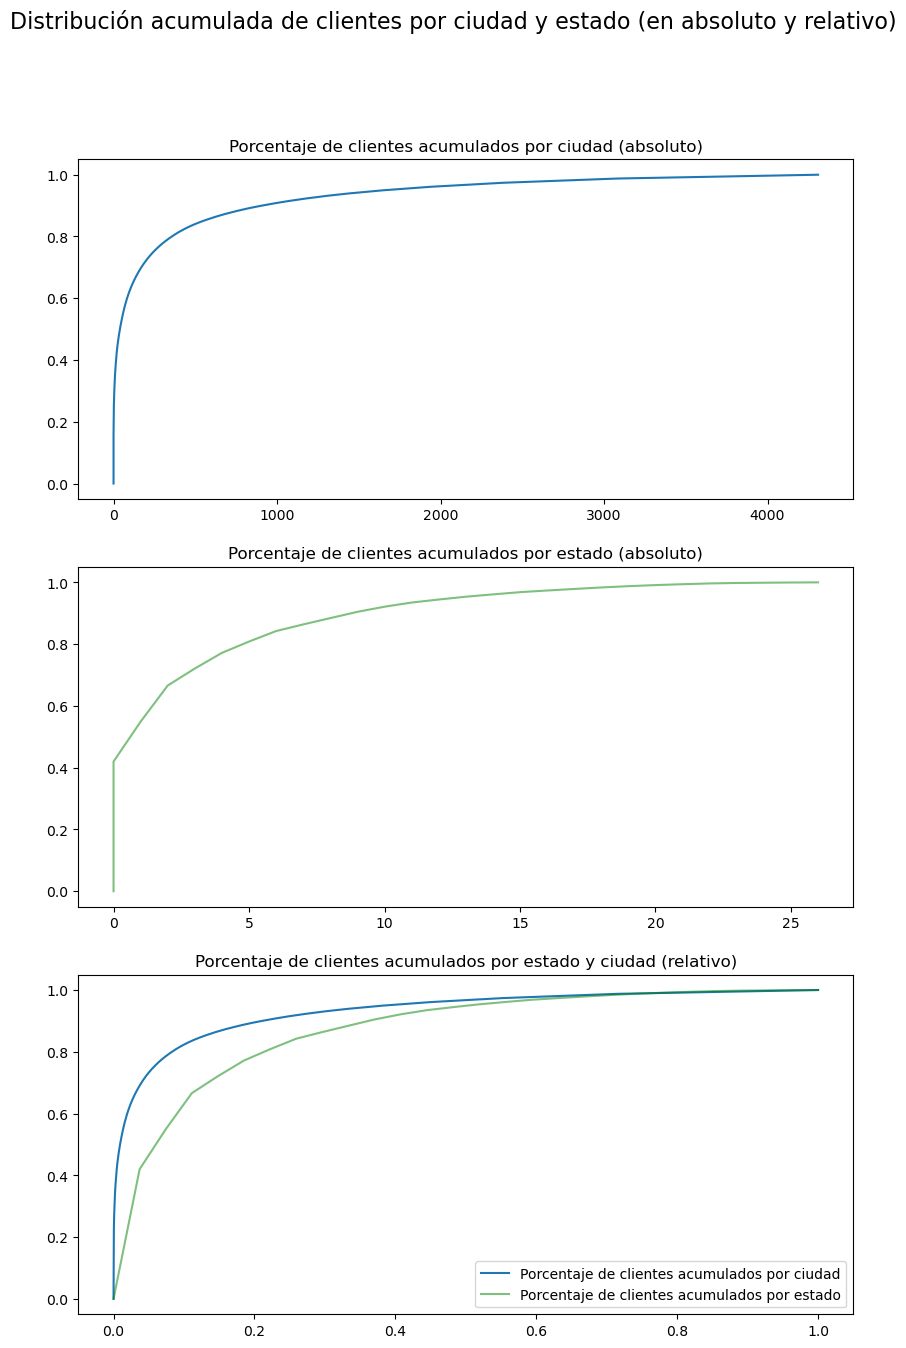

In [21]:
# instanciamos
fig = plt.figure(figsize = (10, 15))
ax1, ax2, ax3 = fig.subplots(nrows = 3, ncols = 1)

# pasamos los valores de los ejes --> añadimos el (0,0) para que empiece en el origen
x1_values = [0] + list(city_gb.index)
y1_values = [0] + list(city_gb["cum_pct_clients_per_city"])
x2_values = [0] + list(state_gb.index)
y2_values = [0] + list(state_gb["cum_pct_clients_per_state"])
x3_values_city = [0] + list(city_gb["cum_pct_city"])
y3_values_city = [0] + list(city_gb["cum_pct_clients_per_city"])
x3_values_state = [0] + list(state_gb["cum_pct_state"])
y3_values_state = [0] + list(state_gb["cum_pct_clients_per_state"])

# pintamos las gráficas y les ponemos título
ax1.plot(x1_values, y1_values)
ax1.title.set_text("Porcentaje de clientes acumulados por ciudad (absoluto)")
ax2.plot(x2_values, y2_values, color = "green", alpha = 0.5)
ax2.title.set_text("Porcentaje de clientes acumulados por estado (absoluto)")
ax3.plot(x3_values_city, y3_values_city, label = "Porcentaje de clientes acumulados por ciudad")
ax3.plot(x3_values_state, y3_values_state, label = "Porcentaje de clientes acumulados por estado", color = "green", alpha = 0.5)
ax3.title.set_text("Porcentaje de clientes acumulados por estado y ciudad (relativo)")
ax3.legend()

# título de la gráfica
fig.suptitle('Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)', fontsize = 16);

- El 80% de los clientes se concentran en 300 ciudades
- El 80% de los clientes se concentran en menos del 10% de las ciudades

- El 80% de los clientes se concentran en 5 estados
- El 80% de los clientes se concentran en el 22% de los estados

## **3.2.- EDA orders_df**

**Información del dataset**

In [22]:
report_df(df = orders_df, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.8+ MB
None

Tenemos un total de 4908 nulos

Cinco primeros registros del dataset:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


**Información de los atributos**

- *order_id* --> id (único) generado en cada pedido. Se utilizará para poder cruzar los pedidos con los pagos
- *customer_id* --> id de compra del cliente --> id que se genera en cada compra (es un id diferente de order_id)
- *order_status* --> estado en el que se encuentra el pedido
- *order_purchase_timestamp* --> fecha y hora en el que se hace el pedido
- *order_approved_at* --> fecha y hora en el que la empresa aprueba el pedido (dato interno de la empresa)
- *order_delivered_carrier_date* --> fecha y hora en el que se entrega el pedido al transportista
- *order_delivered_customer_date* --> fecha y hora en el que se entrega el pedido al cliente
- *order_estimated_delivery_date* --> fecha y hora estimada de entrega del producto al cliente

In [23]:
# Estados en los que se encuentra un pedido
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

- *delivered* --> pedido entregado
- *shipped* --> pedido enviado
- *canceled* --> pedido cancelado
- *unavailable* --> pedido no disponible
- *invoiced* --> pedido facturado
- *processing* --> procesando el pedido
- *created* --> pedido creado
- *approved* --> pedido aprobado

In [24]:
# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
assert (set(orders_df["customer_id"]) ^ set(customers_df["customer_id"])) == set()
assert (set(customers_df["customer_id"]) ^ set(orders_df["customer_id"])) == set()

In [25]:
order_id = orders_df["order_id"].nunique()

print(f'''Tenemos un total de {order_id} pedidos,
un total de {customer_unique_id} customer únicos (de la tabla de customers).
La relación de pedidos por clientes es de {round(order_id/customer_unique_id, 2)}.''')

Tenemos un total de 99441 pedidos,
un total de 96096 customer únicos (de la tabla de customers).
La relación de pedidos por clientes es de 1.03.


*Información y Variables que podemos generar con estos atributos*

Con "order_purchase_timestamp":
* Si el cliente compra por la mañana, tarde, noche
* Si compra en horario laboral
* Si compra por la semana o en fin de semana
* Si compra en días festivos

Con "order_purchase_timestamp" y "order_delivered_customer_date":
* Tiempo que se tarda en entregar un producto al cliente

Con "order_delivered_customer_date" y "order_estimated_delivery_date":
* Si la entrega se realiza a tiempo o no.

## **3.3.- EDA payments_df**

**Información del dataset**

In [26]:
report_df(df = payments_df, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.8+ MB
None

Tenemos un total de 0 nulos

Cinco primeros registros del dataset:


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


**Información de los atributos**

- *order_id* --> id (único) generado en cada pedido. Se utilizará para poder cruzar los pedidos con los pagos
- *payment_sequential* --> secuencia que se crea si el cliente paga con más de un método de pago
- *payment_type* --> mforma de pago untilizados por el cliente
- *payment_installments* --> número de cuotas de pago elegidas por el cliente
- *payment_value* --> valor de la transacción

In [27]:
order_id_pay = payments_df["order_id"].nunique()

print(f'''Tenemos un total de {order_id} pedidos únicos en la tabla de orders.
Tenemos un total de {order_id_pay} pedidos únicos en la tabla de payments.''')

Tenemos un total de 99441 pedidos únicos en la tabla de orders.
Tenemos un total de 99440 pedidos únicos en la tabla de payments.


Hay un pedido en orders que no está en payments, y por lo tanto no podemos asosciarlo a ningún pago (tenemos que eliminarlo). Vemos cuál es:

In [28]:
list((set(orders_df['order_id']) ^ set(payments_df['order_id'])))

['bfbd0f9bdef84302105ad712db648a6c']

In [29]:
# pedido que quiero eliminar
orders_df[orders_df['order_id']=="bfbd0f9bdef84302105ad712db648a6c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00


*Información y Variables que podemos generar con estos atributos*

- *payment_value* --> Podemos saber el valor total de cada transacción (total del pedido) --> con esta variable podemos saber si el cliente gasta mucho o poco
- *payment_installments* --> Podemos saber si el cliente fracciona o no fracciona
- *order_id*, *payment_sequential* y *payment_type* --> podemos saber si hay pedidos que se han pagado con diferentes medios de pago

In [30]:
# valor total de cada pedido
payments_df.groupby('order_id')['payment_value'].sum()

order_id
00010242fe8c5a6d1ba2dd792cb16214     72.19
00018f77f2f0320c557190d7a144bdd3    259.83
000229ec398224ef6ca0657da4fc703e    216.87
00024acbcdf0a6daa1e931b038114c75     25.78
00042b26cf59d7ce69dfabb4e55b4fd9    218.04
                                     ...  
fffc94f6ce00a00581880bf54a75a037    343.40
fffcd46ef2263f404302a634eb57f7eb    386.53
fffce4705a9662cd70adb13d4a31832d    116.85
fffe18544ffabc95dfada21779c9644f     64.71
fffe41c64501cc87c801fd61db3f6244     55.79
Name: payment_value, Length: 99440, dtype: float64

In [31]:
# pedidos en los que el cliente fracciona el pago
payments_df[payments_df['payment_installments']>1]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
...,...,...,...,...,...
103878,2e3d96522c8c378d4135c12a65c977aa,1,credit_card,4,47.62
103879,c45067032fd84f4cf408730ff5205568,1,credit_card,2,198.94
103880,7159096c5aa9be77f7f0c26c01ee9793,1,credit_card,4,280.65
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80


In [32]:
payments_df['payment_installments'].value_counts()

1     52546
2     12413
3     10461
4      7098
10     5328
5      5239
8      4268
6      3920
7      1626
9       644
12      133
15       74
18       27
11       23
24       18
20       17
13       16
14       15
17        8
16        5
21        3
0         2
22        1
23        1
Name: payment_installments, dtype: int64

In [33]:
# métodos de pago
payments_df['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

- *voucher* --> especie de bono o cupón

In [34]:
# pedidos con diferentes medios de pago
payments_df[payments_df['payment_sequential']>1]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
139,82ffe097d8ddbf319a523b9bbe7725d5,2,voucher,1,30.00
...,...,...,...,...,...
103569,fedcd9f7ccdc8cba3a18defedd1a5547,6,voucher,1,8.60
103732,f0a5b7c94819c69d12a1c0458ec74756,2,voucher,1,80.40
103747,cf101c3abd3c061ca9f78c1bbb1125af,3,voucher,1,8.46
103750,d0bff47153ef056bb4f884a2ec2f0691,2,voucher,1,41.89


In [35]:
# medios de pago utilizados en uno de los pedidos
payments_df[payments_df['order_id']=='ea9184ad433a404df1d72fa0a8764232']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
40168,ea9184ad433a404df1d72fa0a8764232,1,credit_card,1,17.78
78613,ea9184ad433a404df1d72fa0a8764232,3,voucher,1,22.49
94151,ea9184ad433a404df1d72fa0a8764232,2,voucher,1,22.49
99425,ea9184ad433a404df1d72fa0a8764232,5,voucher,1,22.47


Determinamos el número de medios de pago que se utilizan en cada pedido

In [36]:
# número de veces que se ha utilizado un medio de pago en cada pedido
payments_df.groupby(['order_id', 'payment_type']).size()

order_id                          payment_type
00010242fe8c5a6d1ba2dd792cb16214  credit_card     1
00018f77f2f0320c557190d7a144bdd3  credit_card     1
000229ec398224ef6ca0657da4fc703e  credit_card     1
00024acbcdf0a6daa1e931b038114c75  credit_card     1
00042b26cf59d7ce69dfabb4e55b4fd9  credit_card     1
                                                 ..
fffc94f6ce00a00581880bf54a75a037  boleto          1
fffcd46ef2263f404302a634eb57f7eb  boleto          1
fffce4705a9662cd70adb13d4a31832d  credit_card     1
fffe18544ffabc95dfada21779c9644f  credit_card     1
fffe41c64501cc87c801fd61db3f6244  credit_card     1
Length: 101686, dtype: int64

In [37]:
# ponemos cada medio de pago en una columna
payment_type = payments_df.groupby(['order_id', 'payment_type']).size().unstack()
payment_type

payment_type,boleto,credit_card,debit_card,not_defined,voucher
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,NaN,1.0,NaN,NaN,NaN
00018f77f2f0320c557190d7a144bdd3,NaN,1.0,NaN,NaN,NaN
000229ec398224ef6ca0657da4fc703e,NaN,1.0,NaN,NaN,NaN
00024acbcdf0a6daa1e931b038114c75,NaN,1.0,NaN,NaN,NaN
00042b26cf59d7ce69dfabb4e55b4fd9,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1.0,NaN,NaN,NaN,NaN
fffcd46ef2263f404302a634eb57f7eb,1.0,NaN,NaN,NaN,NaN
fffce4705a9662cd70adb13d4a31832d,NaN,1.0,NaN,NaN,NaN


In [38]:
# número total de tipo de pagos usados por el cliente para cada pedido
payment_type['total_tipo_pagos'] = payment_type.sum(axis = 1)
payment_type

payment_type,boleto,credit_card,debit_card,not_defined,voucher,total_tipo_pagos
order_id,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,NaN,1.0,NaN,NaN,NaN,1.0
00018f77f2f0320c557190d7a144bdd3,NaN,1.0,NaN,NaN,NaN,1.0
000229ec398224ef6ca0657da4fc703e,NaN,1.0,NaN,NaN,NaN,1.0
00024acbcdf0a6daa1e931b038114c75,NaN,1.0,NaN,NaN,NaN,1.0
00042b26cf59d7ce69dfabb4e55b4fd9,NaN,1.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1.0,NaN,NaN,NaN,NaN,1.0
fffcd46ef2263f404302a634eb57f7eb,1.0,NaN,NaN,NaN,NaN,1.0
fffce4705a9662cd70adb13d4a31832d,NaN,1.0,NaN,NaN,NaN,1.0


In [39]:
payment_type['total_tipo_pagos'].value_counts()

1.0     96479
2.0      2382
3.0       301
4.0       108
5.0        52
6.0        36
7.0        28
8.0        11
9.0         9
11.0        8
12.0        8
10.0        5
13.0        3
15.0        2
14.0        2
19.0        2
22.0        1
21.0        1
26.0        1
29.0        1
Name: total_tipo_pagos, dtype: int64

In [40]:
# pedidos que tienen más de un medio de pago
payment_type[payment_type['total_tipo_pagos']>1]

payment_type,boleto,credit_card,debit_card,not_defined,voucher,total_tipo_pagos
order_id,,,,,,
0016dfedd97fc2950e388d2971d718c7,NaN,1.0,NaN,NaN,1.0,2.0
002f19a65a2ddd70a090297872e6d64e,NaN,NaN,NaN,NaN,2.0,2.0
0071ee2429bc1efdc43aa3e073a5290e,NaN,NaN,NaN,NaN,2.0,2.0
009ac365164f8e06f59d18a08045f6c4,NaN,1.0,NaN,NaN,5.0,6.0
00b4a910f64f24dbcac04fe54088a443,NaN,1.0,NaN,NaN,1.0,2.0
...,...,...,...,...,...,...
ff7400d904161b62b6e830b3988f5cbd,NaN,1.0,NaN,NaN,1.0,2.0
ff978de32e717acd3b5abe1fb069d2b6,NaN,NaN,NaN,NaN,4.0,4.0
ffa1dd97810de91a03abd7bd76d2fed1,NaN,1.0,NaN,NaN,1.0,2.0


# **4. CREACIÓN DE VARIABLES Y DATAFRAME FINAL**

Hasta ahora, se ha hecho un EDA a nivel de pedidos y pagos, pero tenemos que bajarlo a nivel de clientes, ya que es la segmentación que quiero hacer.

Para ello, empezaremos por el dataset de pagos, que es el más grande, e iremos creando creando variables a medida que vayamos bajando hasta llegar al cliente: payments --> orders --> customers --> customers_unique

In [41]:
n_customer_unique = customers_df['customer_unique_id'].nunique()

print(f'payments_shape: {payments_df.shape}')
print(f'orders_shape: {orders_df.shape}')
print(f'customers_shape: {customers_df.shape}')
print(f'customers_unique: {n_customer_unique}')

payments_shape: (103886, 5)
orders_shape: (99441, 8)
customers_shape: (99441, 5)
customers_unique: 96096


Tenemos que ir bajando el nivel desde pedidos (103886) hasta clientes (96096).

## **4.1.- Creación de variables en payments_df**

Vamos a agregar al dataset una columna que indique si el pedido se ha pagado con tarjeta de crédito o no.

In [42]:
payments_df['credit_pay'] = payments_df['payment_type']=='credit_card'
payments_df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,credit_pay
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,True
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,True
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,True
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,True
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,True
...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,False
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,True
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,True
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,True


Hacemos un groupby por order y determinamos algunas métricas : min, mean, max, etc.\
La mayoría de los pedidos se hacen con pago único, por lo que el min, mean, max, sum ... coincidirán.\
En aquellos pedidos que no coincidan, nos va a aportar información importante sobre el cliente:
- Si fracciona o no
- Cuánto fracciona
- Cuánto ha pagado del total

In [43]:
payments_gb = payments_df.groupby('order_id').agg(
    min_pay = ('payment_value', 'min'), # pago mínimo del pedido
    mean_pay = ('payment_value', 'mean'), # pago medio del pedido
    max_pay = ('payment_value', 'max'), # pago máximo del pedido
    total_pay = ('payment_value', 'sum'), # pago total del pedido
    max_seq = ('payment_sequential', 'max'), # número de veces en que se ha fraccionado el pago del pedido
    type_pay = ('payment_type', lambda series: len(set(series))), # número de tipo de pagos utilizado en el pedido
    credit_pay = ('credit_pay', 'sum') # indica si alguna fracción del pago del pedido se ha hecho con credit_card    
)

payments_gb.sample(10)

,min_pay,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay
order_id,,,,,,,
1583de3d51014f31277a5ba28511c32e,134.21,134.21,134.21,134.21,1,1,1
d4732fc61490420e42d4dbdce8c3c6bf,110.42,110.42,110.42,110.42,1,1,1
5e1857259e2b652b8dbdceca9ee2321f,224.83,224.83,224.83,224.83,1,1,1
78a192ee84633d7c3a125c57c6e4d970,47.06,47.06,47.06,47.06,1,1,1
19cf1ad54fe41157e76ef5f1fc4eb56f,64.76,64.76,64.76,64.76,1,1,1
ad2730b7abb692df187294b85fc0705d,146.97,146.97,146.97,146.97,1,1,1
14a695b756de73b46dafb2151dc5ae98,175.46,175.46,175.46,175.46,1,1,1
03e99d63b25fc441524d77bda33ab136,75.65,75.65,75.65,75.65,1,1,1
6eea01cfbca90a278819c163602d0a69,83.56,83.56,83.56,83.56,1,1,1


In [44]:
# Hemos reducido el dataset
print(f'payments_gb_shape: {payments_gb.shape}')
print(f'orders_shape: {orders_df.shape}')
print(f'customers_shape: {customers_df.shape}')

payments_gb_shape: (99440, 7)
orders_shape: (99441, 8)
customers_shape: (99441, 5)


## **4.2.- Join orders_df y payments_gb**

Unimos el dataframe que acabo de generar agregated_payments con el de orders --> el order_id que no estaba asociado a ningún pago se elimina automaticamente

In [45]:
# Agregamos un indice a orders_df
orders_df.set_index('order_id', inplace = True)

In [46]:
# unimos orders_df y payments_gb
orders_with_payments = orders_df.merge(payments_gb, on = 'order_id')

In [47]:
report_df(df = orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, e481f51cbdc54678b7cc49136f2d6af7 to 66dea50a8b16d9b4dee7af250b4be1a5
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99440 non-null  object 
 1   order_status                   99440 non-null  object 
 2   order_purchase_timestamp       99440 non-null  object 
 3   order_approved_at              99280 non-null  object 
 4   order_delivered_carrier_date   97657 non-null  object 
 5   order_delivered_customer_date  96475 non-null  object 
 6   order_estimated_delivery_date  99440 non-null  object 
 7   min_pay                        99440 non-null  float64
 8   mean_pay                       99440 non-null  float64
 9   max_pay                        99440 non-null  float64
 10  total_pay                      99440 non-null  float64
 11  max_seq                        99440 non-null  int64 

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,min_pay,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay
order_id,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.00,12.903333,18.59,38.71,3,2,1
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,141.460000,141.46,141.46,1,1,0
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,179.120000,179.12,179.12,1,1,1
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,72.200000,72.20,72.20,1,1,1
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,28.620000,28.62,28.62,1,1,1


## **4.3.- Convertimos los atributos de fechas**

In [48]:
# convertimos las fechas que vamos a utilizar al formato fechas (están en formato object)
orders_with_payments['order_purchase_timestamp'] =\
pd.to_datetime(orders_with_payments['order_purchase_timestamp'], format = '%Y-%m-%d')

orders_with_payments['order_delivered_customer_date'] =\
pd.to_datetime(orders_with_payments['order_delivered_customer_date'], format = '%Y-%m-%d')

orders_with_payments['order_estimated_delivery_date'] =\
pd.to_datetime(orders_with_payments['order_estimated_delivery_date'], format = '%Y-%m-%d')

In [49]:
report_df(df = orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, e481f51cbdc54678b7cc49136f2d6af7 to 66dea50a8b16d9b4dee7af250b4be1a5
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99440 non-null  object        
 1   order_status                   99440 non-null  object        
 2   order_purchase_timestamp       99440 non-null  datetime64[ns]
 3   order_approved_at              99280 non-null  object        
 4   order_delivered_carrier_date   97657 non-null  object        
 5   order_delivered_customer_date  96475 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99440 non-null  datetime64[ns]
 7   min_pay                        99440 non-null  float64       
 8   mean_pay                       99440 non-null  float64       
 9   max_pay                        99440 non-null  float64       
 10  total_pay                    

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,min_pay,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay
order_id,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.00,12.903333,18.59,38.71,3,2,1
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,141.46,141.460000,141.46,141.46,1,1,0
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,179.12,179.120000,179.12,179.12,1,1,1
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,72.20,72.200000,72.20,72.20,1,1,1
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,28.62,28.620000,28.62,28.62,1,1,1


## **4.4.- Modelo de estrategia RFM**

Usaremos un modelo **RFM**
* R --> RECENCY --> hace cuánto tiempo que se hizo el último pedido
* F --> FRECUENCY --> Si el cliente ha repetido o no
* M --> MONETARY VALUE --> importe medio de lo que paga, si ha fraccionado o no

**Generamos nuevas variables**

Vamos a crear variables útiles extrayendo la información de los pedidos:
- *time_since_last_purchase* --> tiempo que ha pasado entre el pedido y el último pedido. Esta variable puede ser muy útil para que nuestro modelo detecte clientes recientes, y combinado con el número de pedidos totales que realiza el cliente, puede ser muy valiosa para detectar la fidelidad de los clientes.
- *delivery_time* --> tiempo que se ha tardado en entregar el pedido al cliente
- *delay* --> tiempo de retraso en la entrega del pedido

In [50]:
print('Primer pedido:', orders_with_payments['order_purchase_timestamp'].min())
print('Último pedido:', orders_with_payments['order_purchase_timestamp'].max())

Primer pedido: 2016-09-04 21:15:19
Último pedido: 2018-10-17 17:30:18


Como las fechas de los pedidos son antiguas, no podemos tomar como referencia, para crear las nuevas variables, la fecha actual.\
Tomaremos como referencia la fecha del último pedido.

In [51]:
# creamos variables útiles extrayendo la información de los pedidos.
# Por ejemplo: tiempo desde la última compra puede ser muy útil para que nuestro modelo detecte clientes
# recientes y combinando con la variable de pedidos totales podrá ser muy valiosas para segmentar a los clientes
# muy fidelizados.

# fecha referencia --> el último pedido
orders_with_payments['last_purchase'] = orders_with_payments['order_purchase_timestamp'].max()

# tiempo que ha pasado entre el pedido y el último pedido
orders_with_payments['time_since_last_purchase'] =\
orders_with_payments['last_purchase'] - orders_with_payments['order_purchase_timestamp']

# tiempo que se ha tardado en entregar el pedido al cliente
orders_with_payments['delivery_time'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_purchase_timestamp']

# tiempo de retraso en la entrega del pedido
orders_with_payments['delay'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_estimated_delivery_date']

In [52]:
orders_with_payments.head().T

order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c
order_status,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23,2017-11-18 19:45:59,2018-02-13 22:20:29
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00
min_pay,2.0,141.46,179.12,72.2,28.62
mean_pay,12.903333,141.46,179.12,72.2,28.62
max_pay,18.59,141.46,179.12,72.2,28.62


El valor negativo de 'delay' indica que el pedido ha sido entregado al cliente antes de la fecha prevista.

## **4.5.- Join final**

Unimos el dataframe anterior con el de clientes

In [53]:
print(f'orders_with_payments_shape: {orders_with_payments.shape}')
print(f'customers_shape: {customers_df.shape}')

orders_with_payments_shape: (99440, 18)
customers_shape: (99441, 5)


In [54]:
# unimos customers_df y orders_with_payments
# order_id de orders_with_payments desaparece
df_final = pd.merge(customers_df, orders_with_payments, on = 'customer_id')

In [55]:
report_df (df = df_final)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 99439
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   customer_id                    99440 non-null  object         
 1   customer_unique_id             99440 non-null  object         
 2   customer_zip_code_prefix       99440 non-null  int64          
 3   customer_city                  99440 non-null  object         
 4   customer_state                 99440 non-null  object         
 5   order_status                   99440 non-null  object         
 6   order_purchase_timestamp       99440 non-null  datetime64[ns] 
 7   order_approved_at              99280 non-null  object         
 8   order_delivered_carrier_date   97657 non-null  object         
 9   order_delivered_customer_date  96475 non-null  datetime64[ns] 
 10  order_estimated_delivery_date  99440 non-null  datetime64[ns] 
 11  mi

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay,last_purchase,time_since_last_purchase,delivery_time,delay
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,...,146.87,146.87,146.87,1,1,1,2018-10-17 17:30:18,519 days 02:24:43,8 days 19:30:00,-11 days +10:35:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,...,335.48,335.48,335.48,1,1,1,2018-10-17 17:30:18,277 days 20:41:54,16 days 15:52:55,-8 days +12:41:19
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,...,157.73,157.73,157.73,1,1,1,2018-10-17 17:30:18,151 days 01:22:33,26 days 01:51:06,1 days 17:58:51
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,...,173.30,173.30,173.30,1,1,1,2018-10-17 17:30:18,218 days 01:23:40,14 days 23:57:47,-13 days +16:04:25
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,...,252.25,252.25,252.25,1,1,1,2018-10-17 17:30:18,80 days 07:38:48,11 days 11:04:18,-6 days +20:55:48


**Selección de variables**

Selecciono las variables que había creado, así como el identificador único del cliente (customer_unique_id) y elimino la variable last_purchase que ya no necesito

In [56]:
df_final.columns.to_list()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'min_pay',
 'mean_pay',
 'max_pay',
 'total_pay',
 'max_seq',
 'type_pay',
 'credit_pay',
 'last_purchase',
 'time_since_last_purchase',
 'delivery_time',
 'delay']

In [57]:
list_columns = [
    'customer_unique_id',
    'min_pay',
    'mean_pay',
    'max_pay',
    'total_pay',
    'max_seq',
    'type_pay',
    'credit_pay',
    'time_since_last_purchase',
    'delivery_time',
    'delay'
]

# dataframe con las nuevas variables customer_unique_id
df_final = df_final[list_columns]
# agrego el indice 
df_final.set_index('customer_unique_id', inplace= True)
df_final.head()

,min_pay,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1,1,1,519 days 02:24:43,8 days 19:30:00,-11 days +10:35:35
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1,1,1,277 days 20:41:54,16 days 15:52:55,-8 days +12:41:19
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1,1,1,151 days 01:22:33,26 days 01:51:06,1 days 17:58:51
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1,1,1,218 days 01:23:40,14 days 23:57:47,-13 days +16:04:25
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1,1,1,80 days 07:38:48,11 days 11:04:18,-6 days +20:55:48


Limitamos a días las variables de tiempo (podemos despreciar las horas, minutos y segundos)

In [58]:
df_final["time_since_last_purchase"] = df_final["time_since_last_purchase"].dt.days
df_final["delivery_time"] = df_final["delivery_time"].dt.days
df_final["delay"] = df_final["delay"].dt.days

In [59]:
report_df(df = df_final)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   min_pay                   99440 non-null  float64
 1   mean_pay                  99440 non-null  float64
 2   max_pay                   99440 non-null  float64
 3   total_pay                 99440 non-null  float64
 4   max_seq                   99440 non-null  int64  
 5   type_pay                  99440 non-null  int64  
 6   credit_pay                99440 non-null  int64  
 7   time_since_last_purchase  99440 non-null  int64  
 8   delivery_time             96475 non-null  float64
 9   delay                     96475 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 8.3+ MB
None

Tenemos un total de 5930 nulos

Cinco primeros registros del dataset:


,min_pay,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1,1,1,519,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1,1,1,277,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1,1,1,151,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1,1,1,218,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1,1,1,80,11.0,-6.0


In [60]:
len(set(df_final.index))

96095

Me he traido toda la información a nivel de pedidos y pagos.

Ya sólo me falta llevar esa información a nivel de clientes. Tenemos que agrupar por clientes (pasar de 99440 a 96095 registros)

**Tareas que faltan por realizar**

- Imputar las variables con nulos
- Agrupar por clientes
- Estandarizar los datos

## **4.6.- Pipeline y creación de Transformers**

Para realizar las tareas que nos faltan, utilizaremos el Pipeline de sklearn, en el que automatizaremos dichas tareas (*steps*). Cada una de esas tareas la implementaremos mediante un ***Transformer*** (clase con método *fit*, *transform* y *fit-transform*).

No obstante, en la práctica sólo vamos a implementar un método, el **transform**, porque el **fit** (cuando heredamos de ***TransformerMixin***) sólo tiene que devolver el ***self*** y el **fit_transform** se va a crear sólo.

Heredamos también del ***BaseEstimator*** para tener acceso al método de ***get_params() y set_params()***.

Los steps que va a realizar el pipeline son:

1. ***KNNImputer***, que se basa en la misma noción de **métricas de distancia** para imputar los valores nulos en función de los cliente más similares.

2. Dado que en el primer paso nos devuelve un array usamos nuestro propio ***Transformer*** *ArrayToDataFrame* para convertir a DataFrame.

3. Creamos variables a nivel de cliente, haciendo un groupby según el índice ('customer_unique_id'), utilizando el ***Transformer*** *FeatureGenerator*. Creamos las siguientes variables:
    - n_orders --> número total de pedidos de cada cliente
    - amount --> importe total de los pedidos de cada cliente
    - avg_ticket --> importe medio de los pedidos de cada cliente
    - last_purchase --> tiempo que ha pasado desde la última compra de cada cliente
    - first_purchase --> tiempo que ha pasado desde la primera compra de cada cliente
    - mean_delivery_time --> tiempo medio de entrega de los pedidos de cada cliente
    - max_delivery_time -->  tiempo máximo de entrega de los pedidos de cada cliente
    - mean_delay --> tiempo medio de retraso en la entrega de los pedidos de cada cliente
    - max_delay -->  tiempo máximo de retraso en la entrega de los pedidos de cada cliente    

4. Filtramos los outliers con nuestro propio ***Transformer*** *OutlierFilter*. Consideramos outliers aquellos clientes cuyos valores amount y max_delay estén fuera del 99% de todos los valores (ambos).

5. Estandarizamos los valores, usando ***StandardScaler***.

6. Hacemos un ***fit con KMeans*** para calcular la **inertia** de los grupos (la dispersión de los datos al centroide).

Técnica del ***Elbow Curve***: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia. Dicho de otro modo **aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.** --> Con esto sabremos cuál será el **número óptimo de centroides** que tenemos que utilizar para hacer la segmentación de clientes.

In [63]:
# defino los parámetros de entrada que le tengo que pasar
columns = list(df_final.columns) # atributos
index = list(df_final.index) # customers_unique_id

In [64]:
# separamos del pipeline la loop que haremos con el KMeans, para no tener que volver a hacer los primeros 5 pasos para cada k de la loop
pipe_ = Pipeline(steps = [
    ("Imputer", KNNImputer()), # Imputamos los nulos (por defecto, con los 5 clientes más similares) --> Devuelve un array
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)), # Convertimos el array en dataframe --> Devuelve un dataframe
    ("FeatureGenerator", FeatureGenerator()), # Agrupamos por clientes (generamos variables a nivel de clientes) --> Devuelve un dataframe con indice
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])), # considera cliente outlier cuando el percentil es >=0,99 en importe y retraso
    ("StandardScaler", StandardScaler()) # Estandarizamos los valores --> Devuelve un array
    ]
)

**Vemos paso a paso lo que nos devuelve cada uno de los steps del pipeline**

In [65]:
df_final.shape

(99440, 10)

In [66]:
# Paso 1 --> Imputamos los nulos
print(f'antes: {df_final.shape}')
df_step_1 = KNNImputer().fit_transform(df_final) # Le paso un df válido (atríbutos numéricos e índice: customer_unique_id)
print(f'después: {df_step_1.shape}')
df_step_1 # Me devuelve un array

antes: (99440, 10)


después: (99440, 10)


array([[146.87, 146.87, 146.87, ..., 519.  ,   8.  , -11.  ],
       [335.48, 335.48, 335.48, ..., 277.  ,  16.  ,  -8.  ],
       [157.73, 157.73, 157.73, ..., 151.  ,  26.  ,   1.  ],
       ...,
       [ 56.04,  56.04,  56.04, ..., 191.  ,  30.  ,   7.  ],
       [711.07, 711.07, 711.07, ..., 347.  ,  12.  , -19.  ],
       [ 21.77,  21.77,  21.77, ..., 302.  ,   7.  , -13.  ]])

In [67]:
# Paso 2 --> Convertimos el array en dataframe
print(f'antes: {df_step_1.shape}')
df_step_2 =ArrayToDataFrame(columns, index = index).fit_transform (df_step_1) # le paso un array
print(f'después: {df_step_2.shape}')
df_step_2 # Me devuelve un df con el index y columns definidos antes

antes: (99440, 10)
después: (99440, 10)


,min_pay,mean_pay,max_pay,total_pay,max_seq,type_pay,credit_pay,time_since_last_purchase,delivery_time,delay
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,1.0,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,1.0,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,1.0,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,1.0,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,1.0,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,1.0,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,1.0,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,1.0,1.0,191.0,30.0,7.0
73c2643a0a458b49f58cea58833b192e,711.07,711.07,711.07,711.07,1.0,1.0,1.0,347.0,12.0,-19.0


In [68]:
# Paso 3 --> Agrupamos por clientes (customer_unique_id)
print(f'antes: {df_step_2.shape}')
df_step_3 = FeatureGenerator().fit_transform(df_step_2) # le paso un df
print(f'después: {df_step_3.shape}')
df_step_3 # Me devuelve un df más pequeño (con menos clientes)

antes: (99440, 10)


después: (96095, 9)


,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,160.0,160.0,6.0,6.0,-5.0,-5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,163.0,163.0,3.0,3.0,-5.0,-5.0
0000f46a3911fa3c0805444483337064,1,86.22,86.22,585.0,585.0,25.0,25.0,-2.0,-2.0
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,369.0,369.0,20.0,20.0,-12.0,-12.0
0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,336.0,336.0,13.0,13.0,-8.0,-8.0
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2067.42,495.0,495.0,27.0,27.0,-27.0,-27.0
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,84.58,310.0,310.0,30.0,30.0,-3.0,-3.0
ffff371b4d645b6ecea244b27531430a,1,112.46,112.46,617.0,617.0,14.0,14.0,-30.0,-30.0
ffff5962728ec6157033ef9805bacc48,1,133.69,133.69,168.0,168.0,11.0,11.0,-14.0,-14.0


In [69]:
# Paso 4 --> Filtramos los clientes outliers
print(f'antes: {df_step_3.shape}')
df_step_4 = OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"]).fit_transform(df_step_3) # le paso un df, el percentil y las columnas por las que se filtra
print(f'después: {df_step_4.shape}')
outliers = df_step_3.shape[0] - df_step_4.shape[0]
print(f'número de clientes outliers: {outliers}')
df_step_4 # Me devuelve un df más pequeño (sin los clientes outliers)

antes: (96095, 9)
después: (94114, 9)
número de clientes outliers: 1981


,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,160.0,160.0,6.0,6.0,-5.0,-5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,163.0,163.0,3.0,3.0,-5.0,-5.0
0000f46a3911fa3c0805444483337064,1,86.22,86.22,585.0,585.0,25.0,25.0,-2.0,-2.0
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,369.0,369.0,20.0,20.0,-12.0,-12.0
0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,336.0,336.0,13.0,13.0,-8.0,-8.0
...,...,...,...,...,...,...,...,...,...
fffcc512b7dfecaffd80f13614af1d16,1,710.70,710.70,189.0,189.0,12.0,12.0,-7.4,-7.4
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,84.58,310.0,310.0,30.0,30.0,-3.0,-3.0
ffff371b4d645b6ecea244b27531430a,1,112.46,112.46,617.0,617.0,14.0,14.0,-30.0,-30.0
ffff5962728ec6157033ef9805bacc48,1,133.69,133.69,168.0,168.0,11.0,11.0,-14.0,-14.0


In [70]:
# Paso 5 --> Estandarizamos los datos
print(f'antes: {df_step_4.shape}')
df_step_5 = StandardScaler().fit_transform(df_step_4) # le paso un df
print(f'después: {df_step_5.shape}')
df_step_5 # Me devuelve un array

antes: (94114, 9)
después: (94114, 9)


array([[-0.1616401 , -0.05881078, -0.02951108, ..., -0.73208612,
         0.85763554,  0.84047349],
       [-0.1616401 , -0.84771152, -0.84468728, ..., -1.11808667,
         0.85763554,  0.84047349],
       [-0.1616401 , -0.44174159, -0.42519595, ...,  1.71258399,
         1.2080079 ,  1.1896097 ],
       ...,
       [-0.1616401 , -0.26127994, -0.23872377, ...,  0.29724866,
        -2.0621341 , -2.0689949 ],
       [-0.1616401 , -0.11527382, -0.0878547 , ..., -0.08875188,
        -0.19348153, -0.20693513],
       [-0.1616401 , -0.54256353, -0.52937591, ..., -0.60341927,
        -0.4270631 , -0.4396926 ]])

**Haciendo todo el pipeline a la vez**

In [71]:
df_scaled_transformed_sin_outliers = pipe_.fit_transform(df_final) # le damos un df válido (atributos numéricos e indexado por customers_unique_id)
df_scaled_transformed_sin_outliers # nos devuelve un array

array([[-0.1616401 , -0.05881078, -0.02951108, ..., -0.73208612,
         0.85763554,  0.84047349],
       [-0.1616401 , -0.84771152, -0.84468728, ..., -1.11808667,
         0.85763554,  0.84047349],
       [-0.1616401 , -0.44174159, -0.42519595, ...,  1.71258399,
         1.2080079 ,  1.1896097 ],
       ...,
       [-0.1616401 , -0.26127994, -0.23872377, ...,  0.29724866,
        -2.0621341 , -2.0689949 ],
       [-0.1616401 , -0.11527382, -0.0878547 , ..., -0.08875188,
        -0.19348153, -0.20693513],
       [-0.1616401 , -0.54256353, -0.52937591, ..., -0.60341927,
        -0.4270631 , -0.4396926 ]])

# **5. CLUSTERIZACIÓN**

## **5.1.- Elbow Curve**

Usamos el método "elbow curve" para determinar cuál es el k adecuado que debemos usar para realizar la clusterización:

- Aplicamos el algoritmo KMeans para diferentes k, determinando para cada uno de ellos, la métrica sse correspondiente. Para ello usamos un for loop, al que le pasamos el array que obtuvimos tras la aplicación del pipeline --> es como si aplicamos el pipeline (incluyendo el KMeans) k veces.
- Construimos una gráfica en la que se visualiza en el eje x los clusters y en eje y los valores de las métricas sse.

El SSE es la suma de la distancia de cada punto al centroide de su cluster. A medida que aumenta k, el SSE disminuye, pero a un ritmo cada vez menor. **El punto en el que el SSE disminuye más lentamente se conoce como el codo y es el punto óptimo para elegir k**

In [72]:
CALCULATE_ELBOW = True

In [73]:
# Iteramos y probamos con un monton de clusters (centroides)
if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15): # En cada iteracción creamos un KMeans nuevo

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k) # Instancio el modelo KMeans

        clustering_model.fit(df_scaled_transformed_sin_outliers) # entreno el modelo

        sse[k] = clustering_model.inertia_ # nos guardamos una metrica (que en este caso es la inertia_)

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 0 minutes.


**Valores de las métricas para cada modelo** (para cada K)

In [74]:
# suma de la distancia de cada punto al centroide de su cluster
sse

{2: 681644.2217057929,
 3: 558864.3035498455,
 4: 459518.0325201447,
 5: 387299.2481813949,
 6: 345120.7332274496,
 7: 312943.4672610571,
 8: 291440.71607586305,
 9: 273292.295595195,
 10: 258117.88246808152,
 11: 246558.46010490452,
 12: 237128.93095078235,
 13: 228340.18781334622,
 14: 219824.32002922223}

**Visualizamos la curva**

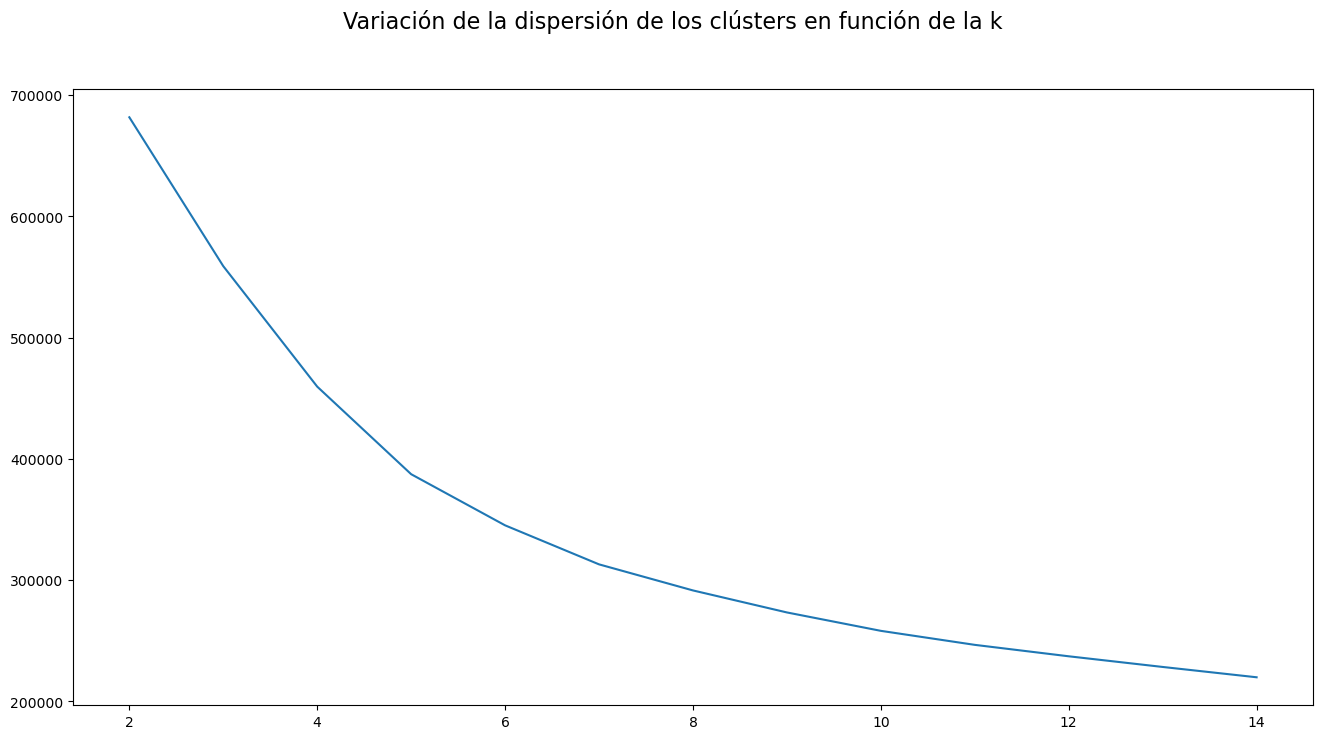

In [75]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys()) # valores de los K
    y_values = list(sse.values()) # valores de las métricas sse para cada K

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

Esta curva me devuelve la suma de las distancias de cada uno de los puntos al centroide en función del número de cluster. Vemos que aumentando el número de clusters, disminuye esa distancia, y lo hace indefinidamente, es decir, la dispersión de cada uno de los puntos respecto al centroide se ha ido haciendo más pequeño. Lo que nosotros buscamos en la curva es el cambio más pronunciado de la pendiente (el codo de la curva):
- k=5 es un buen valor
- Una buena praxis es poner un poco más (6-7), y evaluarlo, porque si encuentro que dos clasters se comportan de igual manera los agrupo y ya me quedarían en 5, pero si cojo 5 clusters, ya no podría hacerlo.

## **5.2.- Segmentación de clientes con la K adecuada**

Una vez determinado el número de centroides o clústeres adecuado, entrenamos nuestro pileline, incluyendo el KMeans. 

A veces, a KMeans se le conoce como **segmentación no supervisada pero guiada**, ya que somos nosotros mismos los que le decimos qué tiene que fijarse (discriminamos unas variables y le pasamos al modelo otras, guiamos al modelo).

**Redefino el pipeline con la K adecuada**

In [76]:
# Instancio el pipeline
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()), # Imputamos los nulos (por defecto, con los 5 clientes más similares) --> Devuelve un array
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)), # Convertimos el array en dataframe --> Devuelve un dataframe
    ("FeatureGenerator", FeatureGenerator()), # Agrupamos por clientes (generamos variables a nivel de clientes) --> Devuelve un dataframe con indice
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])), # considera cliente outlier cuando el percentil es >=0,99 en importe y retraso
    ("StandardScaler", StandardScaler()), # Estandarizamos los valores --> Devuelve un array
    ("Clustering", KMeans(n_clusters = 5)) # hago la segmentacion de clientes (con k=5)
    ]
)

No podemos realizar todos los pasos del pipeline a la vez, porque sino la segmentación la hará sin los clientes outliers. Estos se extrajeron para que no influyeran al determinar el valor de la K adecuada, pero a la hora de hacer la segmentación con la K adecuada, tenemos que tenerlos en cuenta, sino se quedarán fuera de la segmentación.

Primero entrenamos todo el pipeline (**fit**), luego aplicamos los pasos implementados, menos el OutlierFilter (**transform**) y finalmente clusterizamos (**predict**)

**Entrenamos el pipeline**

In [77]:
# El modelo aprende a segmentar los clientes
pipe.fit (df_final) # le paso un df válido (atríbutos numéricos e índice: customer_unique_id)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['min_pay', 'mean_pay', 'max_pay',
                                           'total_pay', 'max_seq', 'type_pay',
                                           'credit_pay',
                                           'time_since_last_purchase',
                                           'delivery_time', 'delay'],
                                  index=['861eff4711a542e4b93843c6dd7febb0',
                                         '290c77bc529b7ac935b93aa66c333dc3',
                                         '060e732b5b29e8181a18229c7b0b2b5e',
                                         '259dac757896d24d7702b...
                                         '5f102dd37243f152aec3607970aad100',
                                         '9c0096673baf55453a50073f12d1a37f',
                                         '2e6a42a9b5cbb0da62988694f18ee295',
                                         '4d221875624017bc47b4d1ce7314a5b7',
                                         'a8654e2af5da6bb72f52c22b164855e1', ...])),
                ('FeatureGenerator', FeatureGenerator()),
                ('OutlierFilter',
                 OutlierFilter(col_to_filter=['amount', 'max_delay'], q=0.99)),
                ('StandardScaler', StandardScaler()),
                ('Clustering', KMeans(n_clusters=5))])

**Pasos: Imputer, ArrayToDataFrame, FeatureGenerator**

In [78]:
print(f'antes: {df_final.shape}')
X_processed = pipe[:3].transform(df_final) # le paso un df válido (atríbutos numéricos e índice: customer_unique_id)
print(f'después: {X_processed.shape}') 
X_processed # me devuelve un df

antes: (99440, 10)
después: (96095, 9)


,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,160.0,160.0,6.0,6.0,-5.0,-5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,163.0,163.0,3.0,3.0,-5.0,-5.0
0000f46a3911fa3c0805444483337064,1,86.22,86.22,585.0,585.0,25.0,25.0,-2.0,-2.0
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,369.0,369.0,20.0,20.0,-12.0,-12.0
0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,336.0,336.0,13.0,13.0,-8.0,-8.0
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2067.42,495.0,495.0,27.0,27.0,-27.0,-27.0
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,84.58,310.0,310.0,30.0,30.0,-3.0,-3.0
ffff371b4d645b6ecea244b27531430a,1,112.46,112.46,617.0,617.0,14.0,14.0,-30.0,-30.0
ffff5962728ec6157033ef9805bacc48,1,133.69,133.69,168.0,168.0,11.0,11.0,-14.0,-14.0


**Pasos: StandardScaler**

In [79]:
print(f'antes: {X_processed.shape}')
X_scaled = pipe["StandardScaler"].transform(X_processed) # le paso un df
print(f'después: {X_scaled.shape}') 
X_scaled # me devuelve un array

antes: (96095, 9)
después: (96095, 9)


array([[-0.1616401 , -0.05881078, -0.02951108, ..., -0.73208612,
         0.85763554,  0.84047349],
       [-0.1616401 , -0.84771152, -0.84468728, ..., -1.11808667,
         0.85763554,  0.84047349],
       [-0.1616401 , -0.44174159, -0.42519595, ...,  1.71258399,
         1.2080079 ,  1.1896097 ],
       ...,
       [-0.1616401 , -0.26127994, -0.23872377, ...,  0.29724866,
        -2.0621341 , -2.0689949 ],
       [-0.1616401 , -0.11527382, -0.0878547 , ..., -0.08875188,
        -0.19348153, -0.20693513],
       [-0.1616401 , -0.54256353, -0.52937591, ..., -0.60341927,
        -0.4270631 , -0.4396926 ]])

**Pasos: Clusterización**

In [80]:
# hacemos el predict --> obtenemos para cada cliente su centroide/clúster.
print(f'antes: {X_scaled.shape}') 
labels = pipe["Clustering"].predict(X_scaled) # le damos un array
print(f'etiquetas establecidas: {labels.shape}') 
labels # nos devuelve un array con las etiquetas de cada cliente (el cluster al que pertenece)

antes: (96095, 9)
etiquetas establecidas: (96095,)


array([2, 2, 3, ..., 0, 2, 0])

*Atributos de los clientes*

Vemos cómo obtener los 9 atributos de cada uno de los clientes

In [84]:
# primer cliente
X_scaled[0]

array([-0.1616401 , -0.05881078, -0.02951108, -0.83074205, -0.84554511,
       -0.72675577, -0.73208612,  0.85763554,  0.84047349])

In [85]:
# tercer cliente
X_scaled[2]

array([-0.1616401 , -0.44174159, -0.42519595,  1.93489186,  1.91140184,
        1.73887854,  1.71258399,  1.2080079 ,  1.1896097 ])

*Posición de los centroides*

In [81]:
# Posición de los k=5 centroides
# Viene definida por las 9 variables (coordenadas de 9 dimensiones)
print(f'{pipe["Clustering"].cluster_centers_ .shape}')
pipe["Clustering"].cluster_centers_ 

(5, 9)


array([[-0.1616401 , -0.23080368, -0.20723245,  1.0217124 ,  1.00109072,
        -0.20973819, -0.21946451, -0.31441906, -0.32744598],
       [-0.14468837,  3.0230705 ,  3.14199128, -0.03228413, -0.04762083,
         0.08651124,  0.07551631, -0.17584768, -0.18819148],
       [-0.1616401 , -0.24583607, -0.22276551, -0.78486532, -0.79981248,
        -0.45429981, -0.46194673, -0.16935533, -0.18289405],
       [-0.15964404, -0.10364013, -0.07613038, -0.03535324, -0.05260782,
         1.6929676 ,  1.66734028,  1.23984387,  1.22159184],
       [ 5.15084662,  0.8284559 , -0.12205956, -0.11738178,  0.43842714,
        -0.03850199,  0.32782799, -0.07833029,  0.37257445]])

In [86]:
# posición del primer centroide
pipe["Clustering"].cluster_centers_[0]

array([-0.1616401 , -0.23080368, -0.20723245,  1.0217124 ,  1.00109072,
       -0.20973819, -0.21946451, -0.31441906, -0.32744598])

*Distancia euclidea entre clientes y centroides*

A cada cliente se le asigna el cluster que corresponde con la menor de las distancias euclideas entre ese cliente y los centroides determinados. Así, si la menor de las distancias euclideas del cliente 0 a los centroides, es la que corresponde con la distancia al centroide 2, a ese cliente se le asigna el cluster 2.

Vemos un ejemplo de cómo se calcula la distancia euclidea

In [98]:
# array (2,2) --> las filas son samples y las columnas son features
X = [[0, 1], 
     [1, 1]]

In [99]:
# distancia entre las filas de X
# nos devuelve un array (2,2) --> resultado de 4 distancias euclideas
euclidean_distances(X=X, Y=None)

array([[0., 1.],
       [1., 0.]])

In [94]:
# distancia entre las filas de X y el origen que es un array (1,2)
# me devuelve un array (2,1)
euclidean_distances(x, [[0,0]])

array([[1.        ],
       [1.41421356]])

Vemos cómo se calcula la distancia entre un cliente a los centroides

In [100]:
# features del cliente 0
X_scaled[0]

array([-0.1616401 , -0.05881078, -0.02951108, -0.83074205, -0.84554511,
       -0.72675577, -0.73208612,  0.85763554,  0.84047349])

In [104]:
# features del centroide 0
pipe["Clustering"].cluster_centers_[0]

array([-0.1616401 , -0.23080368, -0.20723245,  1.0217124 ,  1.00109072,
       -0.20973819, -0.21946451, -0.31441906, -0.32744598])

In [103]:
# distancia del cliente 0 al centroide 0
euclidean_distances([X_scaled[0], pipe["Clustering"].cluster_centers_[0]])

array([[0.        , 3.18914625],
       [3.18914625, 0.        ]])

In [113]:
# cliente 0
# calculamos la distancia del cliente 0 a cada uno de los 5 centroides
# la distancia más corta es con respecto al centroide 2
# este cliente pertenece al cluster 2
dist_0= []
for i in range(0,5):
    dist_0.append(euclidean_distances([X_scaled[0], pipe["Clustering"].cluster_centers_[i]]))
dist_0

[array([[0.        , 3.18914625],
        [3.18914625, 0.        ]]),
 array([[0.        , 4.92653927],
        [4.92653927, 0.        ]]),
 array([[0.        , 1.52503141],
        [1.52503141, 0.        ]]),
 array([[0.        , 3.62894235],
        [3.62894235, 0.        ]]),
 array([[0.       , 5.8196102],
        [5.8196102, 0.       ]])]

In [122]:
# cliente 3
# calculamos la distancia del cliente 3 a cada uno de los 5 centroides
# la distancia más corta es con respecto al centroide 0
# este cliente pertenece al cluster 0
dist_3= []
for i in range(0,5):
    dist_3.append(euclidean_distances([X_scaled[3], pipe["Clustering"].cluster_centers_[i]]))
dist_3

[array([[0.        , 2.14688878],
        [2.14688878, 0.        ]]),
 array([[0.        , 5.64013187],
        [5.64013187, 0.        ]]),
 array([[0.        , 2.95877704],
        [2.95877704, 0.        ]]),
 array([[0.        , 2.24704564],
        [2.24704564, 0.        ]]),
 array([[0.       , 5.7804844],
        [5.7804844, 0.       ]])]

**Asignamos al dataframe procesado las etiquetas de los clientes**

Tenemos que hacerlo al X_processed y no al X_scaled, porque los números serían más difíciles de interpretar tras el escalado

In [82]:
X_processed["cluster"] = labels
X_processed.head()

,n_orders,amount,avg_ticket,last_purchase,first_purchase,mean_delivery_time,max_delivery_time,mean_delay,max_delay,cluster
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,160.0,160.0,6.0,6.0,-5.0,-5.0,2
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,163.0,163.0,3.0,3.0,-5.0,-5.0,2
0000f46a3911fa3c0805444483337064,1,86.22,86.22,585.0,585.0,25.0,25.0,-2.0,-2.0,3
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,369.0,369.0,20.0,20.0,-12.0,-12.0,0
0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,336.0,336.0,13.0,13.0,-8.0,-8.0,0


**Visualización de los grupos en base a las variables del modelo RFM**

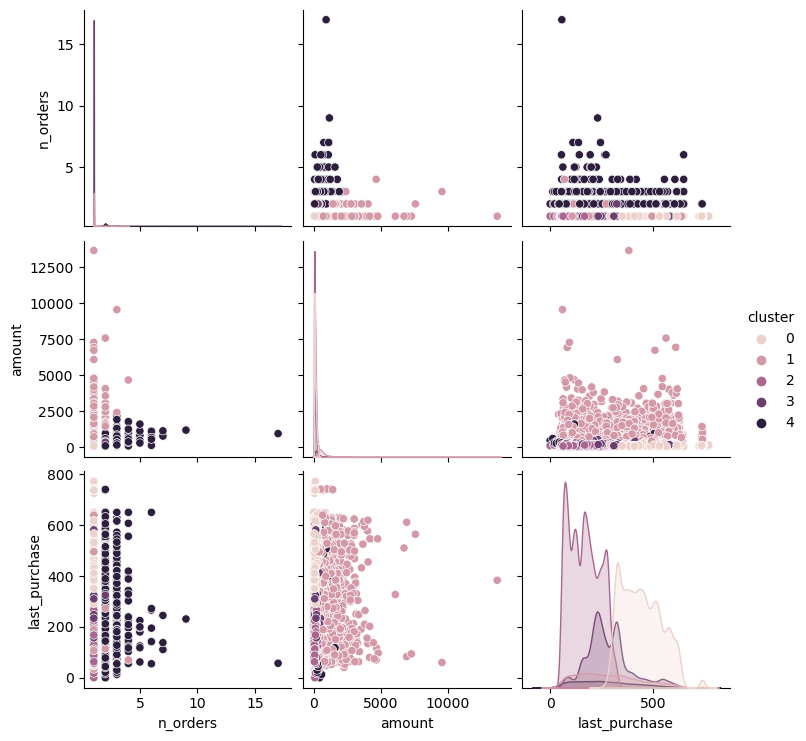

In [83]:
# Recenty --> last_purchase
# Frequency --> n_orders
# Value Monetary --> amount
selected_columns = ['n_orders', 'amount', 'last_purchase']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

# **6. FICHA DE LOS CLIENTES**

Creamos una ***ficha resumen*** de cada grupo de clientes con las principales variables de negocio o con aquellas que no se han utilizado en la segmentación para hacer un seguimiento periódico de los grupos o para enviar como documento al resto de los departamentos de la empresa.

In [115]:
# Instancio la clase DataFrame
ficha_df = pd.DataFrame()

""


Agrego a la ficha las siguientes variables:
- Variables de negocio en base a la etrategia RFM: last_purchase (Recenty), n_orders (Frequency), amount (Value Monetary)
- Variable de interés: mean_delay (retraso medio en la entrega de pediodos)

In [116]:
# Describe de las variables elegidas para cada cluster
for i, col in enumerate(["amount", "n_orders", "last_purchase", "mean_delay"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [117]:
ficha_df

cluster                      0             1           2            3  \
amount        mean  116.948346    764.345125  114.727224   137.283305   
              std    77.200049    561.250794   74.398560    98.217825   
              min    10.070000    328.610000    0.000000    14.860000   
              25%    59.010000    444.287500   57.167500    67.230000   
              50%    95.920000    598.645000   96.155000   112.330000   
              75%   154.900000    863.845000  155.297500   178.270000   
              max   459.140000  13664.080000  408.790000  2092.860000   
n_orders      mean    1.000000      1.013158    1.000000     1.002918   
              std     0.000000      0.120716    0.000000     0.053942   
              min     1.000000      1.000000    1.000000     1.000000   
              25%     1.000000      1.000000    1.000000     1.000000   
              50%     1.000000      1.000000    1.000000     1.000000   
              75%     1.000000      1.000000    1.000000     1.000000   
              max     1.000000      4.000000    1.000000     2.000000   
last_purchase mean  444.743807    283.928186  167.109894   282.860320   
              std    97.103027    149.771254   73.428945   109.408839   
              min   225.000000     34.000000    0.000000    57.000000   
              25%   362.000000    162.000000  103.000000   216.000000   
              50%   436.000000    267.000000  164.000000   263.000000   
              75%   517.000000    384.000000  229.000000   327.000000   
              max   772.000000    743.000000  332.000000   743.000000   
mean_delay    mean  -15.036553    -13.608302  -13.795582     0.545406   
              std     7.053256      8.641666    7.281812    12.897791   
              min  -147.000000    -63.000000  -71.000000   -52.000000   
              25%   -18.000000    -18.000000  -18.000000    -7.000000   
              50%   -14.000000    -13.000000  -13.000000    -2.000000   
              75%   -10.000000     -9.000000   -9.000000     5.000000   
              max     5.000000     40.000000    7.000000   188.000000   

cluster                       4  
amount        mean   277.736297  
              std    199.489132  
              min     34.970000  
              25%    144.460000  
              50%    222.350000  
              75%    349.110000  
              max   2164.400000  
n_orders      mean     2.119735  
              std      0.525403  
              min      2.000000  
              25%      2.000000  
              50%      2.000000  
              75%      2.000000  
              max     17.000000  
last_purchase mean   269.252001  
              std    146.163771  
              min      0.000000  
              25%    152.000000  
              50%    250.000000  
              75%    371.000000  
              max    740.000000  
mean_delay    mean   -12.927777  
              std      6.873694  
              min    -71.000000  
              25%    -16.500000  
              50%    -12.500000  
              75%     -9.000000  
              max     15.666667

In [123]:
# generamos los índices de la ficha (multiindex)
out_index = [
    "Monetarios",
    "Fidelización",
    "Fidelización",
    "Logística"
]

inner_index = [
    "Importe", # amount
    "Nr. de compras", # n_orders
    "Última compra", # last_purchase
    "Retrasos" # mean_delay
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Monetarios', 'Importe', 'Media'),
 ('Monetarios', 'Importe', 'Desviación'),
 ('Monetarios', 'Importe', 'Mínimo'),
 ('Monetarios', 'Importe', 'Perc. 25'),
 ('Monetarios', 'Importe', 'Perc. 50'),
 ('Monetarios', 'Importe', 'Perc. 75'),
 ('Monetarios', 'Importe', 'Máximo'),
 ('Fidelización', 'Nr. de compras', 'Media'),
 ('Fidelización', 'Nr. de compras', 'Desviación'),
 ('Fidelización', 'Nr. de compras', 'Mínimo'),
 ('Fidelización', 'Nr. de compras', 'Perc. 25'),
 ('Fidelización', 'Nr. de compras', 'Perc. 50'),
 ('Fidelización', 'Nr. de compras', 'Perc. 75'),
 ('Fidelización', 'Nr. de compras', 'Máximo'),
 ('Fidelización', 'Última compra', 'Media'),
 ('Fidelización', 'Última compra', 'Desviación'),
 ('Fidelización', 'Última compra', 'Mínimo'),
 ('Fidelización', 'Última compra', 'Perc. 25'),
 ('Fidelización', 'Última compra', 'Perc. 50'),
 ('Fidelización', 'Última compra', 'Perc. 75'),
 ('Fidelización', 'Última compra', 'Máximo'),
 ('Logística', 'Retrasos', 'Media'),
 ('Logística', 'Ret

In [128]:
def generate_multiindex(list_of_tuples, names):
    '''
    Genera los multiíndices que vamos a agregar a un dataframe,
    le damos la lista de multiíndices y 
    el nombre de las columnas de los índices
    '''
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [129]:
# agregamos el multiIndex al dataframe ficha
names = ["Grupo Indicadores", "Indicador", "Estadístico"] # nombres de las columnas de los índices 
index_ficha = generate_multiindex(list_of_tuples = new_multi_index, names = names) # creamos el índice de la ficha
ficha_df.set_index(index_ficha, inplace = True) # indexamos la ficha por index_ficha

In [130]:
ficha_df

cluster                                                0             1  \
Grupo Indicadores Indicador      Estadístico                             
Monetarios        Importe        Media        116.948346    764.345125   
                                 Desviación    77.200049    561.250794   
                                 Mínimo        10.070000    328.610000   
                                 Perc. 25      59.010000    444.287500   
                                 Perc. 50      95.920000    598.645000   
                                 Perc. 75     154.900000    863.845000   
                                 Máximo       459.140000  13664.080000   
Fidelización      Nr. de compras Media          1.000000      1.013158   
                                 Desviación     0.000000      0.120716   
                                 Mínimo         1.000000      1.000000   
                                 Perc. 25       1.000000      1.000000   
                                 Perc. 50       1.000000      1.000000   
                                 Perc. 75       1.000000      1.000000   
                                 Máximo         1.000000      4.000000   
                  Última compra  Media        444.743807    283.928186   
                                 Desviación    97.103027    149.771254   
                                 Mínimo       225.000000     34.000000   
                                 Perc. 25     362.000000    162.000000   
                                 Perc. 50     436.000000    267.000000   
                                 Perc. 75     517.000000    384.000000   
                                 Máximo       772.000000    743.000000   
Logística         Retrasos       Media        -15.036553    -13.608302   
                                 Desviación     7.053256      8.641666   
                                 Mínimo      -147.000000    -63.000000   
                                 Perc. 25     -18.000000    -18.000000   
                                 Perc. 50     -14.000000    -13.000000   
                                 Perc. 75     -10.000000     -9.000000   
                                 Máximo         5.000000     40.000000   

cluster                                                2            3  \
Grupo Indicadores Indicador      Estadístico                            
Monetarios        Importe        Media        114.727224   137.283305   
                                 Desviación    74.398560    98.217825   
                                 Mínimo         0.000000    14.860000   
                                 Perc. 25      57.167500    67.230000   
                                 Perc. 50      96.155000   112.330000   
                                 Perc. 75     155.297500   178.270000   
                                 Máximo       408.790000  2092.860000   
Fidelización      Nr. de compras Media          1.000000     1.002918   
                                 Desviación     0.000000     0.053942   
                                 Mínimo         1.000000     1.000000   
                                 Perc. 25       1.000000     1.000000   
                                 Perc. 50       1.000000     1.000000   
                                 Perc. 75       1.000000     1.000000   
                                 Máximo         1.000000     2.000000   
                  Última compra  Media        167.109894   282.860320   
                                 Desviación    73.428945   109.408839   
                                 Mínimo         0.000000    57.000000   
                                 Perc. 25     103.000000   216.000000   
                                 Perc. 50     164.000000   263.000000   
                                 Perc. 75     229.000000   327.000000   
                                 Máximo       332.000000   743.000000   
Logística         Retrasos       Media        -13.795582     0.545406   
                           

In [139]:
# Número de clientes por cluster
X_processed.groupby("cluster").size().to_frame().T

cluster,0,1,2,3,4
0,31609,6308,39884,15421,2873


In [140]:
# Agregamos los índices al dataframe del tamaño de los clusters a la ficha
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex(list_of_tuples = [("General", "Clúster", "Tamaño")] , names = names), inplace = True)

In [141]:
tamaño_clusters

,,cluster,0,1,2,3,4
Grupo Indicadores,Indicador,Estadístico,,,,,
General,Clúster,Tamaño,31609,6308,39884,15421,2873


In [142]:
# Agregamos el tamaño de los clusters a la ficha
ficha_df = tamaño_clusters.append(ficha_df)
ficha_df

cluster                                                  0             1  \
Grupo Indicadores Indicador      Estadístico                               
General           Clúster        Tamaño       31609.000000   6308.000000   
Monetarios        Importe        Media          116.948346    764.345125   
                                 Desviación      77.200049    561.250794   
                                 Mínimo          10.070000    328.610000   
                                 Perc. 25        59.010000    444.287500   
                                 Perc. 50        95.920000    598.645000   
                                 Perc. 75       154.900000    863.845000   
                                 Máximo         459.140000  13664.080000   
Fidelización      Nr. de compras Media            1.000000      1.013158   
                                 Desviación       0.000000      0.120716   
                                 Mínimo           1.000000      1.000000   
                                 Perc. 25         1.000000      1.000000   
                                 Perc. 50         1.000000      1.000000   
                                 Perc. 75         1.000000      1.000000   
                                 Máximo           1.000000      4.000000   
                  Última compra  Media          444.743807    283.928186   
                                 Desviación      97.103027    149.771254   
                                 Mínimo         225.000000     34.000000   
                                 Perc. 25       362.000000    162.000000   
                                 Perc. 50       436.000000    267.000000   
                                 Perc. 75       517.000000    384.000000   
                                 Máximo         772.000000    743.000000   
Logística         Retrasos       Media          -15.036553    -13.608302   
                                 Desviación       7.053256      8.641666   
                                 Mínimo        -147.000000    -63.000000   
                                 Perc. 25       -18.000000    -18.000000   
                                 Perc. 50       -14.000000    -13.000000   
                                 Perc. 75       -10.000000     -9.000000   
                                 Máximo           5.000000     40.000000   

cluster                                                  2             3  \
Grupo Indicadores Indicador      Estadístico                               
General           Clúster        Tamaño       39884.000000  15421.000000   
Monetarios        Importe        Media          114.727224    137.283305   
                                 Desviación      74.398560     98.217825   
                                 Mínimo           0.000000     14.860000   
                                 Perc. 25        57.167500     67.230000   
                                 Perc. 50        96.155000    112.330000   
                                 Perc. 75       155.297500    178.270000   
                                 Máximo         408.790000   2092.860000   
Fidelización      Nr. de compras Media            1.000000      1.002918   
                                 Desviación       0.000000      0.053942   
                                 Mínimo           1.000000      1.000000   
                                 Perc. 25         1.000000      1.000000   
                                 Perc. 50         1.000000      1.000000   
                                 Perc. 75         1.000000      1.000000   
                                 Máximo           1.000000      2.000000   
                  Última compra  Media          167.109894    282.860320   
                                 Desviación      73.428945    109.408839   
                                 Mínimo           0.000000     57.000000   
                                 Perc. 25       103.000000    216.000000   
                                 Perc. 50      

In [143]:
# le damos un estilo a la ficha
ficha_df = ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)
ficha_df

# **7. CONCLUSIONES**

- Siempre vamos a obtener diferentes resultados, en función de las variables que le pasemos al modelo (modelo guiado no supervisado)
- Cada vez que ejecutemos el notebook, puede ser que lo que antes se llamaba cluster 2, ahora se llame cluster 0 .... pero los números seguirán siendo los mismos.

En función de las características que tenga cada grupo, se le asignará un nombre\
\
CARACTERÍSTICAS DE LOS CLUSTER:
- El cluster 0 es el grupo que lleva más tiempo sin hacer compras. Habría que reactivas a estos clientes
- El cluster 1 es el grupo que más dinero gasta
- El cluster 2 es el grupo con mayor número de clientes
- El cluster 3 es el grupo que mayor retrasos sufre en la entrega de pedidos. Hay que actuar en la logistica
- El cluster 4 es el que realiza mayor número de compras